In [27]:
# Imports

import os
import re
import gzip
import pandas as pd
import numpy as np

# Data Container and Analysis
import anndata as ad
import scanpy as sc
import squidpy as sq

# Machine Learning and Visualization
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

In [28]:
# LOAD PREPROCESSED ANNDATA FROM NOTEBOOK 1

import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd

# Load the saved file created in Notebook 1
adata = ad.read_h5ad("adata_preprocessed.h5ad")

print("\nLoaded AnnData:")
print(adata)
print("Shape:", adata.shape)

# Quick sanity checks
print("\nAvailable layers:", list(adata.layers.keys()))
print("First few obs columns:", adata.obs.columns[:5])
print("First few var columns:", adata.var.columns[:5])


Loaded AnnData:
AnnData object with n_obs × n_vars = 9989 × 24377
    obs: 'sample_id', 'batch'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'
Shape: (9989, 24377)

Available layers: ['counts']
First few obs columns: Index(['sample_id', 'batch'], dtype='object')
First few var columns: Index(['n_cells'], dtype='object')


## Principal Component Analysis (PCA)  

**PCA** is a classical method used to reduce thousands of gene expression values into a smaller set of features, 50 principal components per spatial spot in this analysis. Each principal component captures one of the strongest overall patterns in how genes vary across the tissue.

It works by finding the main directions (or axes) of variation in the data, summarizing the most important patterns while filtering out noise.  

Instead of analazying all 24,000+ genes, **feature selection** can be used to identift the few thousand genes (2000 in this case) that show the biggest biological differences across the spots to give PCA only the high-quality data to work with.

The **highly varaible genes (HVGs)** method is the feature selection method used.

Total Genes before HVG selection: 2000


/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/preprocessing/_highly_varia

Selecting 2000 Highly Variable Genes.
Saved unscaled, log-normalized data to adata.layers['normalized'] for CellPLM input.


/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")



PCA Complete. Results stored in adata.obsm['X_pca'].


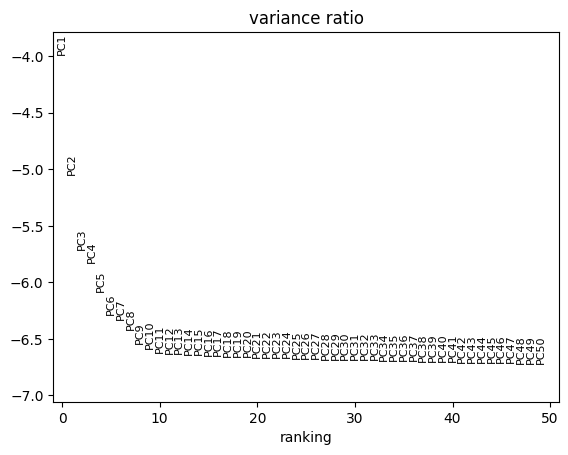

In [46]:
# Feature Selection and Principal Component Analysis

# Identify highly variable genes (HVGs)
print(f"Total Genes before HVG selection: {adata.n_vars}")
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, 
    min_mean=0.0125, 
    max_mean=3, 
    min_disp=0.5,
    batch_key="batch"     # Account for technical differences between slides
)
print(f"Selecting {sum(adata.var.highly_variable)} Highly Variable Genes.")

# Save unscaled, log-normalized data for CellPLM BEFORE scaling
adata.layers['normalized'] = adata.X.copy()
print("Saved unscaled, log-normalized data to adata.layers['normalized'] for CellPLM input.")

# Subset to HVGs (critical for correct PCA)
adata = adata[:, adata.var.highly_variable].copy()

# Scale the data so that high-expression genes do not dominate the PCA result
sc.pp.scale(adata, max_value=10)

# Run PCA
sc.tl.pca(adata, svd_solver='arpack')
print(f"\nPCA Complete. Results stored in adata.obsm['X_pca'].")

# Validate with an elbow plot
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

The cell bellow aims to correct for the **batch effects** introduced by combining multiple distinct slides.
batch effects are non-biological differences caused by variations in sample preparation, imaging, or techniucal sequencing depth differences.
Although normalization corrected for spot-level sequencing depth variations, **Harmony** is used to correct the remaining *slide-wide* technical bias.
It requies the input to be lower dimensional embeddings, rather than the full gene expression matrix, because processing the full matrix iteratively would be computationally expensive

In [47]:
# Batch Correction

# Run Harmony Integration on PCA Results
# This removes technical batch variation (the 'sample_id'/'batch' key) from the data
sc.external.pp.harmony_integrate(
    adata, 
    key='batch', 
    basis='X_pca' # align the data using the 10 PCs determined by the elbow plot
)

2025-11-24 20:39:14,717 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-11-24 20:39:15,510 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-24 20:39:15,532 - harmonypy - INFO - Iteration 1 of 10
2025-11-24 20:39:16,271 - harmonypy - INFO - Iteration 2 of 10
2025-11-24 20:39:16,996 - harmonypy - INFO - Converged after 2 iterations


In [48]:
# Compute the Nearest-Neighbor Graph

# This graph is the foundational structure required for UMAP, Leiden, and spatial correlation analysis.
# We use the Harmony-corrected embeddings as input for this structure.
sc.pp.neighbors(
    adata, 
    use_rep='X_pca_harmony', 
    n_neighbors=15 
)

print("Harmony integration and Nearest-Neighbor Graph complete.")

/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


Harmony integration and Nearest-Neighbor Graph complete.


K-Means clustering complete with 7 clusters.


/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


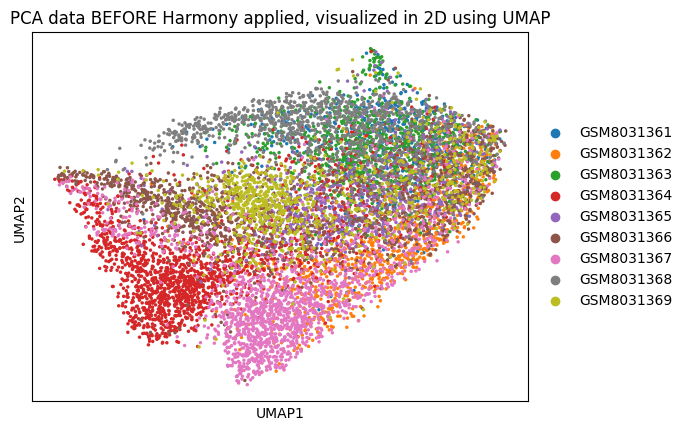

/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


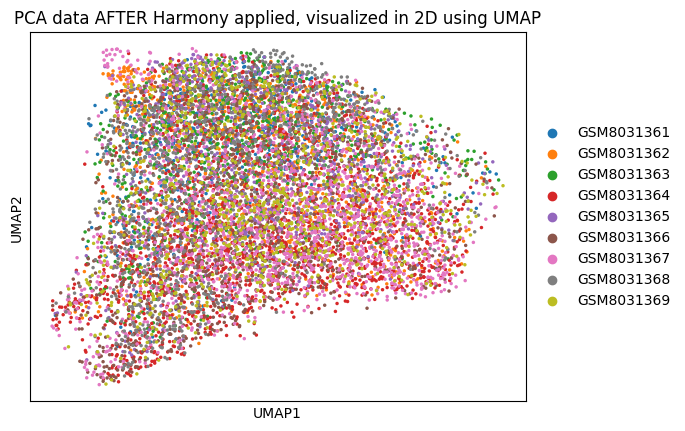

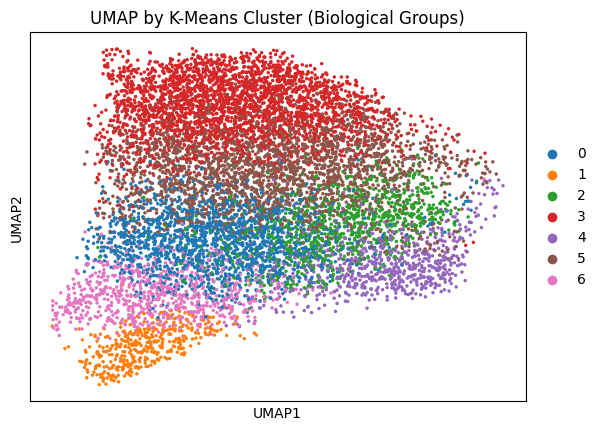

In [ ]:
# UMAP Projection, Clustering (K-Means), and Validation Plots

# ============================================================
# K-Means Clustering on Harmony PCs
# ============================================================

# Use the top 10 Harmony-corrected PCs as input
X_input = adata.obsm['X_pca_harmony'][:, :10]
n_clusters_to_use = 7

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=n_clusters_to_use, random_state=0, n_init='auto')
adata.obs['kmeans'] = kmeans.fit_predict(X_input).astype(str)

print(f"K-Means clustering complete with {n_clusters_to_use} clusters.")

# ============================================================
# UMAP BEFORE HARMONY (using raw PCA)
# ============================================================

# Build neighbor graph using PCA only
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15)

# Compute UMAP from PCA neighbors
sc.tl.umap(adata)

# UMAP colored by batch (before Harmony)
sc.pl.umap(
    adata,
    color='batch',
    size=25,
    save='_pca_batch_before_harmony.png',
    title='PCA data BEFORE Harmony applied, visualized in 2D using UMAP',
    legend_loc='right margin'
)

# ============================================================
# UMAP AFTER HARMONY (using Harmony PCs)
# ============================================================

# Build neighbor graph using Harmony-corrected PCs
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=15)

# Compute UMAP from Harmony neighbors
sc.tl.umap(adata)

# UMAP by batch (after Harmony)
sc.pl.umap(
    adata,
    color='batch',
    size=25,
    save='_harmony_batch_validation.png',
    title='PCA data AFTER Harmony applied, visualized in 2D using UMAP',
    legend_loc='right margin'
)



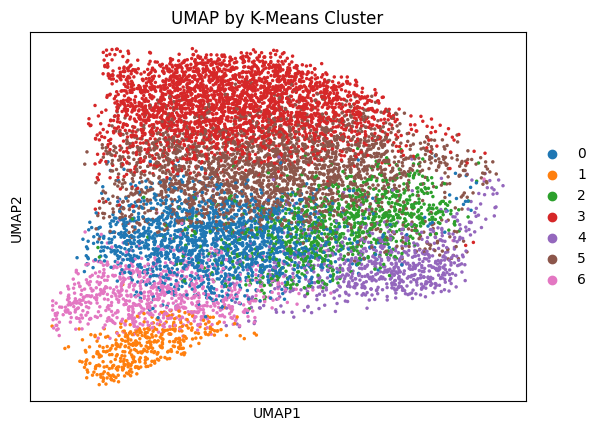

In [63]:
# UMAP by K-Means clusters (after Harmony)
sc.pl.umap(
    adata,
    color='kmeans',
    size=25,
    save='_harmony_kmeans_validation.png',
    title='UMAP by K-Means Cluster',
    legend_loc='right margin'
)

In [57]:
# Print ALL gene names
for g in adata.var.index:
    print(g)

"AL627309.5"
"FAM41C"
"C1orf159"
"SCNN1D"
"AURKAIP1"
"VWA1"
"ATAD3B"
"AL645728.1"
"AL590822.2"
"MORN1"
"AL513477.2"
"RER1"
"HES5"
"RNF207"
"TNFRSF25"
"KLHL21"
"CAMTA1-DT"
"SLC2A5"
"MIR34AHG"
"SRM"
"AL021155.5"
"AGMAT"
"FBLIM1"
"HSPB7"
"LINC01783"
"ALDH4A1"
"KIF17"
"RAP1GAP"
"C1QA"
"C1QC"
"IFNLR1"
"RUNX3"
"AL031432.4"
"RSRP1"
"GPR3"
"AHDC1"
"PHACTR4"
"EPB41"
"TMEM200B"
"ADGRB2"
"SPOCD1"
"IQCC"
"ZSCAN20"
"MEAF6"
"CDCA8"
"BMP8A"
"SMAP2"
"ZFP69B"
"ZFP69"
"EXO5"
"RIMS3"
"ZNF691"
"SLC2A1-AS1"
"GPBP1L1"
"AL604028.1"
"POMGNT1"
"KNCN"
"AL606760.1"
"AC119674.1"
"LINC01135"
"KANK4"
"ROR1"
"SGIP1"
"GADD45A"
"AL158840.1"
"ZRANB2-AS2"
"LRRIQ3"
"TNNI3K"
"AC135803.1"
"DNAJB4"
"GIPC2"
"SYDE2"
"COL24A1"
"LINC01140"
"LRRC8D"
"ZNF326"
"AL627316.1"
"AC104836.1"
"EVI5"
"F3"
"BX005019.1"
"AGL"
"MFSD14A"
"SASS6"
"STXBP3"
"GPSM2"
"TAF13"
"MYBPHL"
"LAMTOR5-AS1"
"KCNA2"
"CD53"
"OVGP1"
"AL390195.2"
"ADORA3"
"WNT2B"
"RHOC"
"TAFA3"
"LINC01357"
"SLC16A1"
"RSBN1"
"DCLRE1B"
"HIPK1"
"DENND2C"
"VANGL1"
"ATP1A1-AS1"
"SPA

#### Clustering Results and Next Steps

The above scatter plot shows groups of spatial spots with similar transcriptional features, where each dot represents a single spot on the tissue.
Spots are clustered together based on how similar their gene-expression profiles are across thousands of genes.

The next phase will focus on making this data biologically meaningful.
That involves mapping the clusters back to their spatial positions on the original tissue (using the .json metadata) and identifying marker genes, genes that are highly expressed within each cluster.
This can help reveal which parts of the tissue have stronger expression from certain cell types or biological processes.

In the context of the Parkinson’s dataset, this is especially relevant since the original study suggested that localized immune-related gene expression within the tissue may play a key role in the degeneration of neurons.



## PCA Metrics

#### Sillhoutte Scoring

Running KMeans on PCA embedding...
Running KMeans on Harmony-corrected PCA...
Plotting PCA vs Harmony UMAP side-by-side…


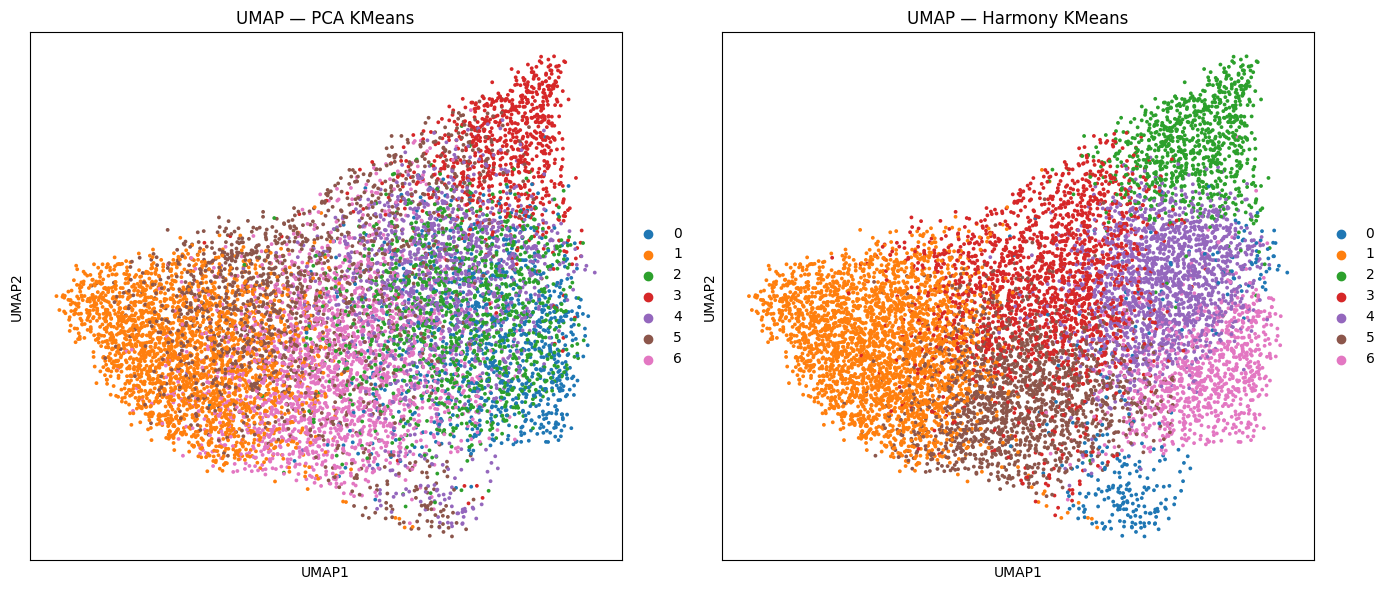

Saved combined figure to: figures/umap_pca_vs_harmony_side_by_side.png


In [33]:
###############################################################
# PCA + HARMONY SIDE-BY-SIDE UMAP WITH KMEANS
#
# This cell:
#   1) Runs KMeans on PCA
#   2) Runs KMeans on Harmony PCA
#   3) Plots both UMAPs side-by-side
###############################################################

from sklearn.cluster import KMeans
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# -----------------------------------------------------
# 1. Run KMeans on PCA
# -----------------------------------------------------
X_pca = adata.obsm["X_pca"]
k = 7

print("Running KMeans on PCA embedding...")
adata.obs["pca_kmeans"] = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_pca).astype(str)

# -----------------------------------------------------
# 2. Run KMeans on Harmony PCA
# -----------------------------------------------------
X_harmony = adata.obsm["X_pca_harmony"]
print("Running KMeans on Harmony-corrected PCA...")
adata.obs["harmony_kmeans"] = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_harmony).astype(str)

# -----------------------------------------------------
# 3. Ensure UMAP exists
# -----------------------------------------------------
if "X_umap" not in adata.obsm:
    print("UMAP not found. Computing UMAP…")
    sc.tl.umap(adata)

# -----------------------------------------------------
# 4. Plot side-by-side
# -----------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

print("Plotting PCA vs Harmony UMAP side-by-side…")

sc.pl.umap(
    adata,
    color="pca_kmeans",
    ax=axes[0],
    show=False,
    size=30,
    title="UMAP — PCA KMeans"
)

sc.pl.umap(
    adata,
    color="harmony_kmeans",
    ax=axes[1],
    show=False,
    size=30,
    title="UMAP — Harmony KMeans"
)

plt.tight_layout()

save_path = "figures/umap_pca_vs_harmony_side_by_side.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved combined figure to: {save_path}")
###############################################################

In [34]:
###############################################################
# SILHOUETTE SCORE — PCA EMBEDDING
#
# Measures: “How well do PCA clusters separate?”
# Higher score = tighter clusters + larger gaps between clusters.
###############################################################

from sklearn.metrics import silhouette_score
import numpy as np

# -------------------------------------------------------------
# 1. Extract the PCA embedding created earlier by Scanpy.
#
#   adata.obsm["X_pca"] is a matrix of shape:
#       (n_spots, n_PCs)
#
#   Example: (≈10k spots, 50 PCs)
#
#   Each row = one spot’s coordinates in PCA space.
# -------------------------------------------------------------
X_pca = adata.obsm["X_pca"]
print("PCA embedding shape:", X_pca.shape)

# -------------------------------------------------------------
# 2. Use the KMeans labels you already computed for PCA.
#
#   These labels belong to PCA, so they must be used here.
#
#   Convert strings to integers for sklearn.
# -------------------------------------------------------------
labels_pca = adata.obs["pca_kmeans"].astype(int).values

# -------------------------------------------------------------
# 3. Compute silhouette score.
#
#   - metric="euclidean" is the standard for embedding spaces.
#   - The score ranges from:
#       -1 → very bad clustering
#        0 → overlapping clusters
#       +1 → well separated clusters
#
#   This evaluates *how well PCA clustering performed*.
# -------------------------------------------------------------
print("Computing Silhouette Score for raw PCA embedding…")

sil_pca = silhouette_score(X_pca, labels_pca, metric="euclidean")

print(f"Silhouette Score (PCA): {sil_pca:.4f}")

PCA embedding shape: (9989, 50)
Computing Silhouette Score for raw PCA embedding…
Silhouette Score (PCA): 0.0335


In [35]:
################################################################
# SILHOUETTE SCORE — HARMONY-CORRECTED PCA
#
# WHY:
#   Harmony reduces batch effects. After correction, the embedding
#   should better reflect *biological* structure rather than 
#   technical differences between samples.
#
# WHAT WE TEST:
#   If Harmony improves or worsens cluster separation.
#
# IMPORTANT:
#   Use the *same clustering labels* (pca_kmeans) for a fair comparison.
################################################################

from sklearn.metrics import silhouette_score
import numpy as np

# -------------------------------------------------------------
# 1. Extract the Harmony-corrected PCA embedding.
#
#   This lives in:
#       adata.obsm["X_pca_harmony"]
#
#   Harmony returns the same number of PCs — typically 50.
#   But only the top 10 PCs are meaningful (based on elbow plot),
#   so we restrict to the first 10 columns for stability.
# -------------------------------------------------------------
X_harmony = adata.obsm["X_pca_harmony"][:, :10]
print("Harmony PCA embedding shape:", X_harmony.shape)

# -------------------------------------------------------------
# 2. Use the SAME labels as PCA (pca_kmeans).
#
#   This ensures the comparison is 100% fair:
#     - same number of clusters
#     - same assignments
#     - only embedding space differs
# -------------------------------------------------------------
labels_harmony = adata.obs["pca_kmeans"].astype(int).values

# -------------------------------------------------------------
# 3. Compute silhouette score in Harmony space.
#
#   Interpretation:
#       Score ↑ → Harmony improved cluster separation
#       Score ↓ → Harmony mixed clusters (common)
#
#   NOTE: Harmony's goal is not “separate clusters tightly”
#         but “remove batch artifacts.”
# -------------------------------------------------------------
print("Computing Silhouette Score for Harmony-corrected PCA…")

sil_harmony = silhouette_score(X_harmony, labels_harmony, metric="euclidean")

print(f"Silhouette Score (Harmony PCA): {sil_harmony:.4f}")

Harmony PCA embedding shape: (9989, 10)
Computing Silhouette Score for Harmony-corrected PCA…
Silhouette Score (Harmony PCA): 0.0745


#### Batch-Mixing

In [ ]:
from sklearn.metrics import silhouette_samples   # <-- you were missing this import

# BATCH MIXING — HARMONY

X_harmony = adata.obsm["X_pca_harmony"]
batch_labels = adata.obs["batch"].values

sil_harmony_batch = silhouette_samples(X_harmony, batch_labels)
batch_asw_harmony = sil_harmony_batch.mean()

print("Batch Mixing ASW (Harmony):", round(batch_asw_harmony, 6))

Batch Mixing ASW (Harmony): -0.071629


In [37]:
###############################################################
# BATCH MIXING — PCA (NO HARMONY)
###############################################################

from sklearn.metrics import silhouette_samples

X_pca = adata.obsm["X_pca"]
batch_labels = adata.obs["batch"].values

sil_pca_batch = silhouette_samples(X_pca, batch_labels)
batch_asw_pca = sil_pca_batch.mean()

print("Batch Mixing ASW (PCA):", round(batch_asw_pca, 6))

Batch Mixing ASW (PCA): -0.037787


#### Compactness

In [38]:
###############################################################
# INTRA-CLUSTER VARIANCE (COMPACTNESS METRIC)
#
# GOAL:
#   Measure how “tight” or “spread out” each cluster is.
#
# WHY IT MATTERS:
#   Silhouette score tells cluster SEPARATION.
#   This metric tells cluster COMPACTNESS.
#
#   Together they explain:
#       - are clusters distinct?
#       - are clusters internally coherent?
#
# WHAT WE DO:
#   For each cluster:
#       1. Extract its PCA embedding points
#       2. Compute its centroid
#       3. Compute variance of distances to the centroid
#   Then report:
#       - per-cluster compactness
#       - mean compactness across all clusters
#
# INTERPRETATION:
#       Lower = better (tighter clusters)
###############################################################

import numpy as np

# -------------------------------------------------------------
# 1) Use PCA embedding (before Harmony)
# -------------------------------------------------------------
X_pca = adata.obsm["X_pca"][:, :10]  # top 10 PCs
labels = adata.obs["pca_kmeans"].astype(int).values
unique_clusters = np.unique(labels)

cluster_variances = {}

# -------------------------------------------------------------
# 2) Compute variance for each cluster
# -------------------------------------------------------------
for c in unique_clusters:
    cluster_points = X_pca[labels == c]

    # skip empty clusters (rare but safe)
    if cluster_points.shape[0] < 2:
        cluster_variances[c] = np.nan
        continue

    # centroid
    centroid = cluster_points.mean(axis=0)

    # squared distances to centroid
    dists = np.linalg.norm(cluster_points - centroid, axis=1)

    # variance of distances
    var = np.var(dists)

    cluster_variances[c] = var
    print(f"Cluster {c}: variance = {var:.4f}")

# -------------------------------------------------------------
# 3) Mean compactness
# -------------------------------------------------------------
compactness_mean = np.nanmean(list(cluster_variances.values()))

print("\n=== FINAL COMPACTNESS METRIC ===")
print(f"Mean intra-cluster variance (PCA): {compactness_mean:.4f}")
print("\nInterpretation:")
print("Lower is better (tighter clusters).")
print("Compare PCA vs Harmony to see which embedding forms tighter groups.")

Cluster 0: variance = 3.2990
Cluster 1: variance = 0.8500
Cluster 2: variance = 1.9948
Cluster 3: variance = 2.5381
Cluster 4: variance = 4.4337
Cluster 5: variance = 3.8035
Cluster 6: variance = 1.3728

=== FINAL COMPACTNESS METRIC ===
Mean intra-cluster variance (PCA): 2.6131

Interpretation:
Lower is better (tighter clusters).
Compare PCA vs Harmony to see which embedding forms tighter groups.


In [39]:
###############################################################
# INTRA-CLUSTER VARIANCE — HARMONY PCA (COMPACTNESS METRIC)
#
# GOAL:
#   Measure how “tight” clusters are AFTER Harmony batch correction.
#
# WHY:
#   - Harmony may spread clusters slightly while mixing batches.
#   - This metric shows whether Harmony keeps clusters compact.
#
# MEANING:
#   Lower = better (tighter clusters)
#
# COMPARISON YOU WILL DO:
#   PCA compactness
#       vs
#   Harmony compactness
#
#   If Harmony increases compactness → even better embedding
#   If Harmony decreases compactness → expected, Harmony mixes more
###############################################################

import numpy as np

# -------------------------------------------------------------
# 1) Extract Harmony embedding
# -------------------------------------------------------------
X_harmony = adata.obsm["X_pca_harmony"][:, :10]   # top 10 PCs
labels = adata.obs["pca_kmeans"].astype(int).values
unique_clusters = np.unique(labels)

cluster_variances_harmony = {}

# -------------------------------------------------------------
# 2) Compute variance for each cluster
# -------------------------------------------------------------
for c in unique_clusters:
    cluster_points = X_harmony[labels == c]

    # Skip clusters that are too small
    if cluster_points.shape[0] < 2:
        cluster_variances_harmony[c] = np.nan
        continue

    # Compute centroid of the cluster in Harmony space
    centroid = cluster_points.mean(axis=0)

    # Compute distances from harmony embedding to centroid
    dists = np.linalg.norm(cluster_points - centroid, axis=1)

    # Variance of distances = cluster compactness
    var = np.var(dists)

    cluster_variances_harmony[c] = var
    print(f"Cluster {c}: variance = {var:.4f}")

# -------------------------------------------------------------
# 3) Compute overall summary score
# -------------------------------------------------------------
compactness_mean_harmony = np.nanmean(list(cluster_variances_harmony.values()))

print("\n=== FINAL COMPACTNESS METRIC (HARMONY) ===")
print(f"Mean intra-cluster variance (Harmony): {compactness_mean_harmony:.4f}")
print("\nInterpretation:")
print("Lower is better (tighter clusters).")
print("Compare to PCA to judge how Harmony affects compactness.")

Cluster 0: variance = 2.7850
Cluster 1: variance = 0.8550
Cluster 2: variance = 1.9530
Cluster 3: variance = 2.3277
Cluster 4: variance = 3.9743
Cluster 5: variance = 2.8969
Cluster 6: variance = 1.3527

=== FINAL COMPACTNESS METRIC (HARMONY) ===
Mean intra-cluster variance (Harmony): 2.3064

Interpretation:
Lower is better (tighter clusters).
Compare to PCA to judge how Harmony affects compactness.


#### Metrics Comparison

In [40]:
###############################################################
# SUMMARY TABLE OF ALL METRICS
#
# This cell gathers:
#   - Silhouette (PCA and Harmony)
#   - Compactness (PCA and Harmony)
#   - Batch mixing (PCA and Harmony)
#
# and prints a clean comparison table.
###############################################################

import pandas as pd

# Make sure these variables exist:
# sil_pca
# sil_harmony
# compactness_mean
# compactness_mean_harmony
# batch_asw_pca
# batch_asw_harmony

results = {
    "Metric": [
        "Silhouette (cluster separation)",
        "Compactness (intra-cluster variance)",
        "Batch mixing (ASW)"
    ],
    "PCA": [
        sil_pca,
        compactness_mean,
        batch_asw_pca
    ],
    "Harmony": [
        sil_harmony,
        compactness_mean_harmony,
        batch_asw_harmony
    ]
}

df_summary = pd.DataFrame(results)
df_summary.index = ["Separation", "Compactness", "Batch Mixing"]

print("\n========================")
print(" FINAL METRIC SUMMARY")
print("========================\n")
display(df_summary)

print("\nInterpretation guide:")
print("  Higher silhouette is better.")
print("  Lower compactness (variance) is better.")
print("  Lower batch ASW is better (means batches are mixed).")


 FINAL METRIC SUMMARY



,Metric,PCA,Harmony
Separation,Silhouette (cluster separation),0.033476,0.074499
Compactness,Compactness (intra-cluster variance),2.613134,2.306368
Batch Mixing,Batch mixing (ASW),-0.037787,-0.071629



Interpretation guide:
  Higher silhouette is better.
  Lower compactness (variance) is better.
  Lower batch ASW is better (means batches are mixed).


## Extra: Load JSON Files

The provided JSON files contain the spatial metadata for every Visium spot on each slide, including coordinates and whether the spot actually overlaps tissue. Some spots fall on empty areas of the slide and have no meaningful expression data. After loading the JSON files, we keep only the spots marked as tissue=True so downstream analysis focuses on real biological material.

Filtering to tissue-only spots also ensures that the remaining rows line up with the expression matrix, meaning each spatial entry corresponds directly to the same spot in the data.

In [41]:
# Load JSON Files — Spatial Coordinates and Metadata Per Spot

import gzip, json, pandas as pd
from pathlib import Path

data_dir = "GSE253975_data"
print(os.listdir(data_dir))

json_dir = Path(data_dir)
json_files = sorted(json_dir.glob("*.json.gz"))

coords_list = []

for file_path in json_files:
    sample_id = file_path.stem.split("_")[0]  # e.g. GSM8031360
    with gzip.open(file_path, "rt") as f:
        data = json.load(f)
        oligos = pd.DataFrame(data["oligo"])
        oligos["sample_id"] = sample_id
        coords_list.append(oligos)

coords_df = pd.concat(coords_list, ignore_index=True)
coords_df = coords_df.rename(columns={"imageX": "x_coord", "imageY": "y_coord"})

coords_df.head()

['GSM8031369_T2465.txt.gz', 'GSM8031368_V11U14-042-C1.json.gz', 'GSM8031367_V11U14-040-A1.json.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031364_V11U14-040-C1.json.gz', 'GSM8031361_V11U14-042-A1.json.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031362_V11U14-042-D1.json.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031366_V11U14-044-C1.json.gz', 'GSM8031365_V11U14-044-A1.json.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031363_V11U14-042-B1.json.gz', 'combined_metadata.json', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031369_V11U14-040-B1.json.gz', 'GSM8031365_T4839.txt.gz']


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
0,4825,30073,0,0,53.25297,5938.0490,5803.2710,NaN,GSM8031361
1,4875,30160,1,1,53.25297,5866.8457,5762.1787,NaN,GSM8031361
2,4925,30073,0,2,53.25297,5938.1963,5721.3433,NaN,GSM8031361
3,4975,30160,1,3,53.25297,5866.9937,5680.2510,NaN,GSM8031361
4,5025,30073,0,4,53.25297,5938.3440,5639.4160,NaN,GSM8031361


In [42]:
# Filter out spots that do not actually contain tissue.
# 'tissue=True' marks spots where RNA was captured, so keeping only these
# ensures we work with meaningful spatial data

coords_tissue = coords_df[coords_df["tissue"] == True].copy()

print("Coords Tissue Shape:", coords_tissue.shape)
coords_tissue.head()

Coords Tissue Shape: (9989, 9)


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
1303,5975,31900,21,23,53.25297,4442.9326,4858.4043,True,GSM8031361
1304,6025,31813,20,24,53.25297,4514.2837,4817.5690,True,GSM8031361
1305,6075,31900,21,25,53.25297,4443.0806,4776.4766,True,GSM8031361
1306,6125,31813,20,26,53.25297,4514.4310,4735.6416,True,GSM8031361
1307,6175,31900,21,27,53.25297,4443.2285,4694.5493,True,GSM8031361


In [43]:
# Ensure the number of spots matches exactly before merging
if adata.n_obs != coords_tissue.shape[0]:
    print(f"Mismatch: AnnData has {adata.n_obs} spots, but Coords has {coords_tissue.shape[0]}.")
    print("Please ensure both are sorted by Sample ID before merging.")
else:
    print(f"Spot counts match ({adata.n_obs}). Proceeding with merge...")

    # Assign Spatial Coordinates
    # T ake the x and y image coordinates from the dataframe
    # AnnData expects this as a numpy array in .obsm['spatial']
    adata.obsm['spatial'] = coords_tissue[['x_coord', 'y_coord']].values

    # Add other metadata from the JSONs to adata.obs
    adata.obs['array_row'] = coords_tissue['row'].values
    adata.obs['array_col'] = coords_tissue['col'].values

    print("Spatial coordinates successfully added to adata.obsm['spatial'].")

Spot counts match (9989). Proceeding with merge...
Spatial coordinates successfully added to adata.obsm['spatial'].


#### Align Spatial Coordinates With PCA Data

Now that we have both the spatial coordinates (from the JSON files) and the PCA results (from the expression matrix), they can be brought together. Since the tissue-only spots in the JSON file line up with the columns of the PCA matrix, we can directly attach PCA values to the matching spatial spots. This lets us visualize PCA patterns on the actual tissue layout.


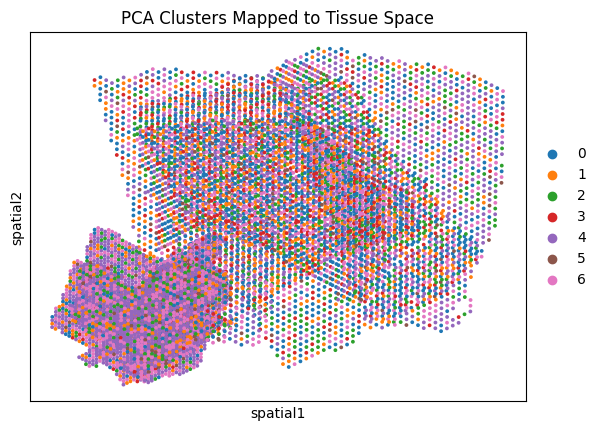

In [44]:
# Spatial Visualization of PCA-Harmony Clusters

# We use 'embedding' with basis='spatial' to plot the coordinates loaded manually.
sc.pl.embedding(
    adata,
    basis="spatial",
    color="kmeans",  # This accesses the clusters from the Harmony/PCA step
    size=30, 
    title="PCA Clusters Mapped to Tissue Space",
    save="_pca_harmony_spatial_map.png"
)